# Genetic hash mask generator

In this project, our goal is to use a genetic algorithm to find the most efficient masks for breaking passwords using a brute-force program such as hashcat or jhon-the-ripper.

## Requirements

We start with a wordlist (in our case we used weakpass_4), that gets stored in wordlists/original/weakpass_4.txt.
This wordlist contains a list of newline-separated passwords that will be our goal to break with the masks we generate.

## Step 1: Prepare the wordlist for usage

We need to make some changes to our wordlist before being able to use it.

### Step 1.1: Separate wordlist into the password length

Our first step for preparing the wordlist is diving it into smaller lists based on the length of the password.
The chosen wordlist (weakpass_4) has passwords that go from 1 to 30 characters, so after this step we should end with 30 smaller wordlists in the wordlists/processed folder.

In this step we also filter passwords that don't match the masks we will generate in the next steps (comprised of at most the ?a charset in hashcat).

In [2]:
%%script echo skipping

wordlist_path = "wordlists/original/weakpass_4.txt"
output_path = "wordlists/processed"

!python scripts/splitWordlist.py -i $wordlist_path -o $output_path

skipping


### Step 1.2: Sort and remove duplicates from the wordlists

The next step is to remove any duplicate passwords from each of the wordlists, so we don´t have unecessary data.

Immediately after, we sort the wordlist and overwrite the original one.
This part is necessary for speeding up the next step, which is to create a search tree from the wordlist.

WARNING: The sorting part wasn't done in an optimal way and may require a lot of memory to complete

In [3]:
%%script echo skipping

processed_wordlist_path = "wordlists/processed"

!python scripts/sortAndUniqueWordlists.py -i $processed_wordlist_path

skipping


### Step 1.3: Create the search tree for the wordlists:

In order to drastically improve the speed of finding the number of password a mask matches in the wordlist, and to drastically reduce the memory usage, we create a search tree for each wordlist.

This tree stores the matches of each charset of the mask, recursively. This way, finding the matches of a given mask requires simply traversing the tree once and getting the value at the leaf node.

To create the tree, a binary search is performed in the sorted wordlist, repeatedly recursevely for each character in the password.

In this step, we also define a maximum depth for the tree. Wordlists with a passord length greater than the maximum depth are not processed.
This is done because the size of the tree grows exponentially with the length of the password, and at the same time, long passwords are used much less frequently.
Due to these reasons, it makes more sense to use other ways to check the number of matches of a long mask (such as using a regex in the file).

In [4]:
%%script echo skipping

processed_wordlist_path = "wordlists/processed"
tree_path = "wordlists/trees"
max_depth = 15

!python scripts/createWordlistTree.py -i $processed_wordlist_path -o $tree_path -d $max_depth

skipping


## Step 2: Evaluate the metric of current methods

Before creating and running an algorithm to search for the most optimal masks, we first need to get a baseline by evaluating the metrics for the current methods that are used.
For the baseline, the following mask collections were chosen:

- [Corporate Masks](https://github.com/golem445/Corporate_Masks): Collection of masks with 8-14 characters created based on 1.5 million NTLM hashes. The masks are divided based on their length. We are considering they are ordered based on their priority.
- [Extreme Breach Masks](https://github.com/sean-t-smith/Extreme_Breach_Masks): Collection of masks with 8-16 characters created based on terabytes of password breach datasets. These masks were created considering the frequency of the passwords present in the databases and divided according to their runtime. When calculating their baseline, we are considering the last set of masks that isn´t compressed (1-year) because they include all masks in the previous sets.

### Step 2.1: Deciding fitness function

In order to evaluate the baseline, we need to define a metric for their fitness.
The first obvious parameter for our metric should be the percentage of passwords that it recovers in our dataset.
Considering that time is a limited resource in a real world scenario, it makes sense to impose a penalty for masks that are very costly.

With these considerations, it was decided to use the following fitness function:
- We first decide on a desired maximum cost for our masks
- Next, we calculate the match ratio for the masks by calculating how the percentage of the passwords they recover in the dataset.
- If the masks don't go above the maximum cost, their fitness is the previously calculated match ratio.
- If they go over the maximum cost, their fitness is calculated by first scaling their match ratio considering their cost.
This way, if a mask has double the maximum cost, their match ratio will be halved. Lastly, we calculate their fitness by applying a penalty percentage to their fitness.

With this fitness function, we aim to prioritize masks that recover as many passwords as possible, while keeping their cost as low as possible. An optimal mask can have a larger cost than the maximum, but suffers a penalty from doing so.

In [5]:
from utils.Mask import Mask, MaskCharset
from utils.WordlistTree import WordlistTree
from utils.MaskIndividual import MaskIndividual

def fitness_function_template(individual: MaskIndividual, wordlist_tree: WordlistTree, max_cost: int, cost_penalty: float) -> float:
    matches = individual.get_matches(wordlist_tree)
    match_ratio = matches / wordlist_tree.wordlist_len
    
    if individual.cost <= max_cost:
        return match_ratio
    
    scaled_match_ratio = match_ratio * (max_cost / individual.cost)
    
    return scaled_match_ratio * ( 1 - cost_penalty )

### Step 2.2 Choosing the parameters

The previously created fitness function depends on the following parameters:

- max_cost: The maximum desired cost for our masks
- cost_penalty: Percentage penalty that is applied to masks that go above the desired maximum cost

To decide the maximum cost, we chose a desired run time of around 10 hours on an RTX 3070 Ti, benchmarked at a speed of 76146.5 MH/s with NTLM hashes.
For the cost penalty, we decided on a 5% penalty to not discourage too much more costly masks, since they can be useful when your available time is larger than the previously stipulated one.

Thus, we have decided on the following parameters:

- max_cost: $5 * 10^{15}$
- cost_penalty: 5%

In [6]:
max_cost = 5 * 10**15
cost_penalty = 0.05

### Step 2.3: Calculating the baseline fitness

Now it's time to calculate the baseline fitness for the chosen mask collections.
In this step, for each collection we'll start with a single mask and continously add the next mask, calculating the total fitness of the set, until the fitness goes down, indicating our mask is too costly.
Then, we'll return the set with the maximum fitness found.
This is done because the masks are ordered to their priority (or at least we assume they are, since that's the order hashcat will use them).

In [24]:
import cloudpickle
import os
import json

corporate_masks_files = "baseline/Corporate_Masks/corp_{len}.hcmask"
extreme_breach_masks_files = "baseline/Extreme_Breach_Masks/14 1-year/1-year_{len}.hcmask"
wordlist_folder = "wordlists/trees"
output_file = "results/baseline.json"

min_len = 8
max_len = 15

def get_best_result_mask_file(mask_file: str, wordlist_tree: WordlistTree, max_cost: int, cost_penalty: float) -> dict:
    
    last_fitness = 0
    
    if not os.path.exists(mask_file):
        return {
            "fitness": 0,
            "masks": [],
            "cost": 0
        }
    
    with open(mask_file, "r") as f:
        masks = []
        for line in f:
            new_mask = Mask.from_str(line.strip())
            masks.append(new_mask)
            
            individual = MaskIndividual(masks, 0)
        
            fitness = fitness_function_template(individual, wordlist_tree, max_cost, cost_penalty)
            
            if fitness >= last_fitness:
                last_fitness = fitness            
            else:
                masks.pop()
                break
                
    return {
            "fitness": last_fitness,
            "masks": [str(mask) for mask in masks],
            "cost": MaskIndividual(masks, 0).cost
        }

best_results = {
    "corporate": {},
    "extreme_breach": {}
}

if not os.path.exists(output_file): 
    for len in range(min_len, max_len + 1):
        corporate_masks_file = corporate_masks_files.format(len=len)
        extreme_breach_masks_file = extreme_breach_masks_files.format(len=len)
        
        with open(os.path.join(wordlist_folder, f"{len}.pkl"), "rb") as f:
            wordlist_tree = cloudpickle.load(f)
            
            print(f"Processing word length: {len}")

            best_result = get_best_result_mask_file(corporate_masks_file, wordlist_tree, max_cost, cost_penalty)        
            print(f"Corporate Masks Best fitness: {best_result['fitness']}. Cost: {best_result['cost']}")
            best_results["corporate"][len] = best_result
        
            best_result = get_best_result_mask_file(extreme_breach_masks_file, wordlist_tree, max_cost, cost_penalty)
            print(f"Extreme Breach Masks Best fitness: {best_result['fitness']}. Cost: {best_result['cost']}")
            best_results["extreme_breach"][len] = best_result
            
    with open(output_file, "w") as f:
        json.dump(best_results, f)

Processing word length: 8
Corporate Masks Best fitness: 0.9720793376298054. Cost: 1605171098613760
Extreme Breach Masks Best fitness: 0.9997047772466525. Cost: 4999855044508416
Processing word length: 9
Corporate Masks Best fitness: 0.5622941244056113. Cost: 4999603084300800
Extreme Breach Masks Best fitness: 0.9559869870321556. Cost: 4997928685184000
Processing word length: 10
Corporate Masks Best fitness: 0.3869147685368694. Cost: 4998028389760000
Extreme Breach Masks Best fitness: 0.8467867662609967. Cost: 4988401456221184
Processing word length: 11
Corporate Masks Best fitness: 0.20811756818543767. Cost: 4989306592000000
Extreme Breach Masks Best fitness: 0.444392950532486. Cost: 2834403868825600
Processing word length: 12
Corporate Masks Best fitness: 0.08592738299737888. Cost: 4986552000000000
Extreme Breach Masks Best fitness: 0.17558914878961016. Cost: 4411987691520000
Processing word length: 13
Corporate Masks Best fitness: 0.03263954859553724. Cost: 4863360000000000
Extreme B

### Step 2.4: Analyzing baseline results

Now that we calculated the fitness for the baseline collections, we can analyze their results:

In [29]:
import pandas as pd

with open("results/baseline.json", "r") as f:
    best_results = json.load(f)

corporate_results = [
    {
        "length": length,
        "fitness": result["fitness"],
        "cost": result["cost"]
    }
    for length, result in best_results["corporate"].items()
]

extreme_breach_results = [
    {
        "length": length,
        "fitness": result["fitness"],
        "cost": result["cost"]
    }
    for length, result in best_results["extreme_breach"].items()
]

results_df = pd.DataFrame(corporate_results).merge(pd.DataFrame(extreme_breach_results), on="length", suffixes=("_corporate", "_extreme_breach"))

results_df

,length,fitness_corporate,cost_corporate,fitness_extreme_breach,cost_extreme_breach
0,8,0.972079,1605171098613760,0.999705,4999855044508416
1,9,0.562294,4999603084300800,0.955987,4997928685184000
2,10,0.386915,4998028389760000,0.846787,4988401456221184
3,11,0.208118,4989306592000000,0.444393,2834403868825600
4,12,0.085927,4986552000000000,0.175589,4411987691520000
5,13,0.032640,4863360000000000,0.065720,4394348800000000
6,14,0.030719,4940000000000000,0.034780,1857600000000000
7,15,0.000000,0,0.187582,3600000000000000


We can see that, in most cases, the Extreme Breach Masks significantly outperform the Corporate Masks.
This could indicate that the Corporate Masks aren't properly sorted by their priority, however this would also represent an issue when using them in hahscat.
At the same time, we can see that the Corporate Masks best fitness happens with a cost very close to the maximum cost, while the Extreme Breachs often achieves its best fitness at a lower cost than was allowed.

## Step 3: Preparing the Genetic Algorithm

Now that we have the wordlists prepared and our baseline results, we can focus on preparing the genetic algorithm for execution.
We are using a simple custom made GeneticAlgorithm class defined in scripts/utils/GeneticAlgorithm.py.

Our individuals are defined in scripts/utils/MaskIndividual.py and can hold a list of masks, up to **max_masks** (defined during creation).
They also define functions for crossover and mutation, as described below:

- Crossover: A number between **1** and **max_masks** is chosen from the parents in order to create the children, following a normal distribution centered around the average number of masks in the parents.
- Mutation: Randomly chooses between one of the following mutation methods, making sure to keep the number of masks between **1** and **max_masks**:
    - Insertion mutation: Insert a randomly created new mask in the individual
    - Deletion mutation: Randomly removes one of the masks from the individual
    - Mask mutation: Randomly changes one of the characters in one of the masks of the individual

We just need to create helper functions that call the already implemented genetic operators described above:

In [9]:
from utils.MaskIndividual import MaskIndividual
    
def crossover_function(parent1: MaskIndividual, parent2: MaskIndividual) -> list[MaskIndividual]:
    return MaskIndividual.crossover(parent1, parent2)

def mutation_function(individual: MaskIndividual) -> MaskIndividual:
    return MaskIndividual.mutate(individual)

## Step 3.1: Creating a Runner for the algorithm

In this step, we create a Runner class that will help with loading the wordlist tree and running the genetic algorithm.

In [10]:
import os
import numpy as np
import cloudpickle

from utils.GeneticAlgorithm import GeneticAlgorithm
from utils.MaskIndividual import MaskIndividual


class Runner:
    def __init__(self, word_length: int, wordlist_folder: str, max_masks: int, max_cost: int, cost_penalty: float):
        self.max_masks = max_masks
        self.max_cost = max_cost
        self.cost_penalty = cost_penalty
        
        self.load_wordlist(wordlist_folder, word_length)
        
        self.fitness_function = lambda individual: fitness_function_template(individual, self.wordlist_tree, self.max_cost, self.cost_penalty)
        
    def load_wordlist(self, wordlist_folder: str, word_length: int):
        with open(os.path.join(wordlist_folder, f"{word_length}.pkl"), "rb") as f:
            self.wordlist_tree = cloudpickle.load(f)
        
    def run(self, 
            population_size: int, n_generations: int, 
            crossover_rate: float, mutation_rate: float, 
            elitism: int, tournament_size: int, 
            verbose: bool=False, seed: int=np.random.randint(10000000)) -> GeneticAlgorithm:        
        ga = GeneticAlgorithm(population_size, n_generations, crossover_rate, mutation_rate, elitism, tournament_size, self.fitness_function, crossover_function, mutation_function)
        
        np.random.seed(seed)
        
        individuals = [ MaskIndividual.generate_random(self.max_masks, self.wordlist_tree.word_len) for _ in range(population_size) ]
        
        ga.run(individuals, verbose)
        
        return ga

### Step 3.2: Test Run

In this step, we do a test run to check if the previous steps were done correctly.

In [11]:
import cloudpickle

outfolder = "results"

wordlist_folder = r"wordlists/trees"
word_length = 8
max_masks = 10

runner = Runner(word_length, wordlist_folder, max_masks, max_cost, cost_penalty)

population_size = 30
n_generations = 30

crossover_rate = 1.0
mutation_rate = 0.1
elitism = 1
tournament_size = 3

seed = 23

ga = runner.run(population_size, n_generations, crossover_rate, mutation_rate, elitism, tournament_size, verbose=False, seed=seed)

with open(os.path.join(outfolder, f"ga_{word_length}_{seed}.pkl"), "wb") as f:
    cloudpickle.dump(ga, f)

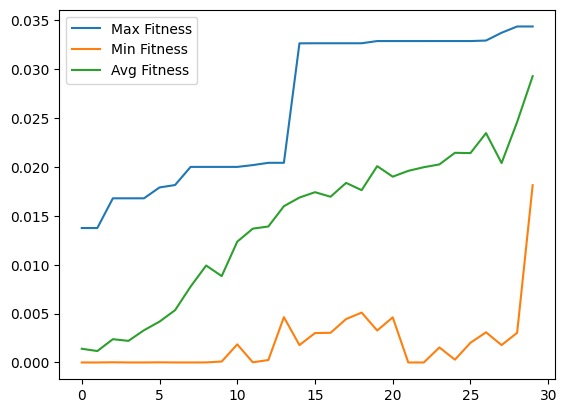

Best individual:
?u?a?u?a?l?l?a?l
?u?a?l?a?l?l?a?l
?u?s?s?u?d?u?s?a
?d?a?u?a?l?l?a?l
?a?d?a?d?l?a?a?l
?d?l?s?a?a?d?a?a
?a?u?a?d?l?a?a?l
?l?a?l?a?d?d?l?l
?a?s?l?l?u?s?l?l
?d?l?s?a?a?d?a?a
Cost: 63155809886208, fitness: 0.034360838376964374, matches: 15360625/447038714 (3.44%)


In [12]:
import cloudpickle
import matplotlib.pyplot as plt

outfolder = "results"

with open(os.path.join(outfolder, f"ga_{word_length}_{seed}.pkl"), "rb") as f:
    ga = cloudpickle.load(f)

plt.plot(ga.run_stats["max_fitness"], label="Max Fitness")
plt.plot(ga.run_stats["min_fitness"], label="Min Fitness")
plt.plot(ga.run_stats["avg_fitness"], label="Avg Fitness")

plt.legend()
plt.show()

best_individual = ga.run_stats["best_individual"][-1]
max_fitness = ga.run_stats["max_fitness"][-1]
best_individual = ga.run_stats["best_individual"][-1]
max_fitness = ga.run_stats["max_fitness"][-1]
best_individual_matches = best_individual.get_matches(runner.wordlist_tree)

print("Best individual:")
print(best_individual)
print(f"Cost: {best_individual.cost}, fitness: {max_fitness}, matches: {best_individual_matches}/{runner.wordlist_tree.wordlist_len} ({best_individual_matches / runner.wordlist_tree.wordlist_len * 100:.2f}%)")


We can see that the Genetic Algorithm is working properly and we can evolve an individual to improve their fitness.

### Step 3.3: Optimizing Parameters

Our next step is finding the best parameters for the Genetic Algorithm.
The parameters we have to choose are as follows:

- population_size: Number of individuals in each generation
- n_generations: Number of generations
- crossover_rate: Chance for a crossover between individuals
- mutation_rate: Chance for a mutation between individuals
- elitism: Number of individuals selected for elitism
- tournament_size: Number of individuals chosen for the tournament
- max_masks: Maximum number of masks available for each individual

For optimizing the parameters, we are running our tests on the wordlist tree of size 10, because it offers a greater degree of complexity compared to size 8.

In [13]:
%%script echo skipping

import optuna

wordlist_folder = r"wordlists/trees"
word_length = 10

def objective(trial):
    population_size = trial.suggest_int("population_size", 10, 300)
    n_generations = trial.suggest_int("n_generations", 10, 300)
    crossover_rate = trial.suggest_float("crossover_rate", 0.5, 1.0)
    mutation_rate = trial.suggest_float("mutation_rate", 0.01, 0.5)
    elitism = trial.suggest_int("elitism", 1, 5)
    tournament_size = trial.suggest_int("tournament_size", 3, 5)
    max_masks = trial.suggest_int("max_masks", 5, 30)
    
    runner = Runner(word_length, wordlist_folder, max_masks, max_cost, cost_penalty)
    
    ga = runner.run(population_size, n_generations, crossover_rate, mutation_rate, elitism, tournament_size, verbose=False)
    
    return ga.run_stats["max_fitness"][-1]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=20)

study.best_params

[I 2025-01-26 20:20:17,453] A new study created in memory with name: no-name-7ef4650b-29fc-4005-b740-7759d5f67f04
[I 2025-01-26 20:21:59,030] Trial 0 finished with value: 0.02525660293320522 and parameters: {'population_size': 20, 'n_generations': 80, 'crossover_rate': 0.8441875125566787, 'mutation_rate': 0.3328675789002472, 'elitism': 1, 'tournament_size': 3, 'max_masks': 25}. Best is trial 0 with value: 0.02525660293320522.
[I 2025-01-26 20:22:48,762] Trial 2 finished with value: 0.07370770069472943 and parameters: {'population_size': 17, 'n_generations': 139, 'crossover_rate': 0.5244073283343736, 'mutation_rate': 0.012928001741092498, 'elitism': 1, 'tournament_size': 4, 'max_masks': 15}. Best is trial 2 with value: 0.07370770069472943.
[I 2025-01-26 20:23:19,560] Trial 9 finished with value: 0.1553048516208512 and parameters: {'population_size': 127, 'n_generations': 44, 'crossover_rate': 0.8232509036333584, 'mutation_rate': 0.3347225798216875, 'elitism': 3, 'tournament_size': 4, 'm

{'population_size': 265,
 'n_generations': 299,
 'crossover_rate': 0.6744781413262715,
 'mutation_rate': 0.2349130096540825,
 'elitism': 5,
 'tournament_size': 5,
 'max_masks': 29}

Based on the test results, we have decided on the following values for the paramters:

- population_size: 265
- n_generations: 300
- crossover_rate: 0.675
- mutation_rate: 0.235
- elitism: 5
- tournament_size: 5
- max_masks: 30

## Step 4: Running the algorithm

Now we're ready to run the algorithm in order to find the best masks.
In this step, we'll execute the algorithm 10 times for each wordl length between 8 and 15.
All results for a word length are saved in a .pkl, that we can later load and analyze.

In [20]:
n_runs = 10

wordlist_folder = r"wordlists/trees"
word_lengths = [8, 9, 10, 11, 12, 13, 14, 15]
base_seed = 23

population_size = 265
n_generations = 300
crossover_rate = 0.675
mutation_rate = 0.235
elitism = 5
tournament_size = 5
max_masks = 30

seeds = np.random.randint(10000000, size=n_runs)

for word_length in word_lengths:
    print(f"Word length: {word_length}")
    
    filename = f"ga_{word_length}_results.pkl"
    filepath = os.path.join(outfolder, filename)
    
    if os.path.exists(filepath):
        print("Skipping")
        continue    
    
    runner = Runner(word_length, wordlist_folder, max_masks, max_cost, cost_penalty)
    results = []
    
    for n_run in range(n_runs):
        seed = seeds[n_run]
        
        print(f"Run {n_run + 1}/{n_runs}")
        ga = runner.run(population_size, n_generations, crossover_rate, mutation_rate, elitism, tournament_size, verbose=False, seed=seed)
        
        best_individual = ga.run_stats["best_individual"][-1]
        max_fitness = ga.run_stats["max_fitness"][-1]
        best_individual_matches = best_individual.get_matches(runner.wordlist_tree)
        
        results.append({
            "seed": seed,
            "word_length": word_length,
            "ga": ga,
            "best_individual": best_individual,
            "max_fitness": max_fitness,
            "best_individual_matches": best_individual_matches,
        })
        
    with open(filepath, "wb") as f:
        cloudpickle.dump(results, f)

Word length: 8
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Word length: 9
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Word length: 10
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Word length: 11
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Word length: 12
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Word length: 13
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Word length: 14
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Word length: 15
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


## Step 5: Analyzing results

After running the algorithm, we can analyze the results obtained and compare them to the baseline.
First, we can plot the 10 runs for each word length to see how their maximum fitness improved overtime:

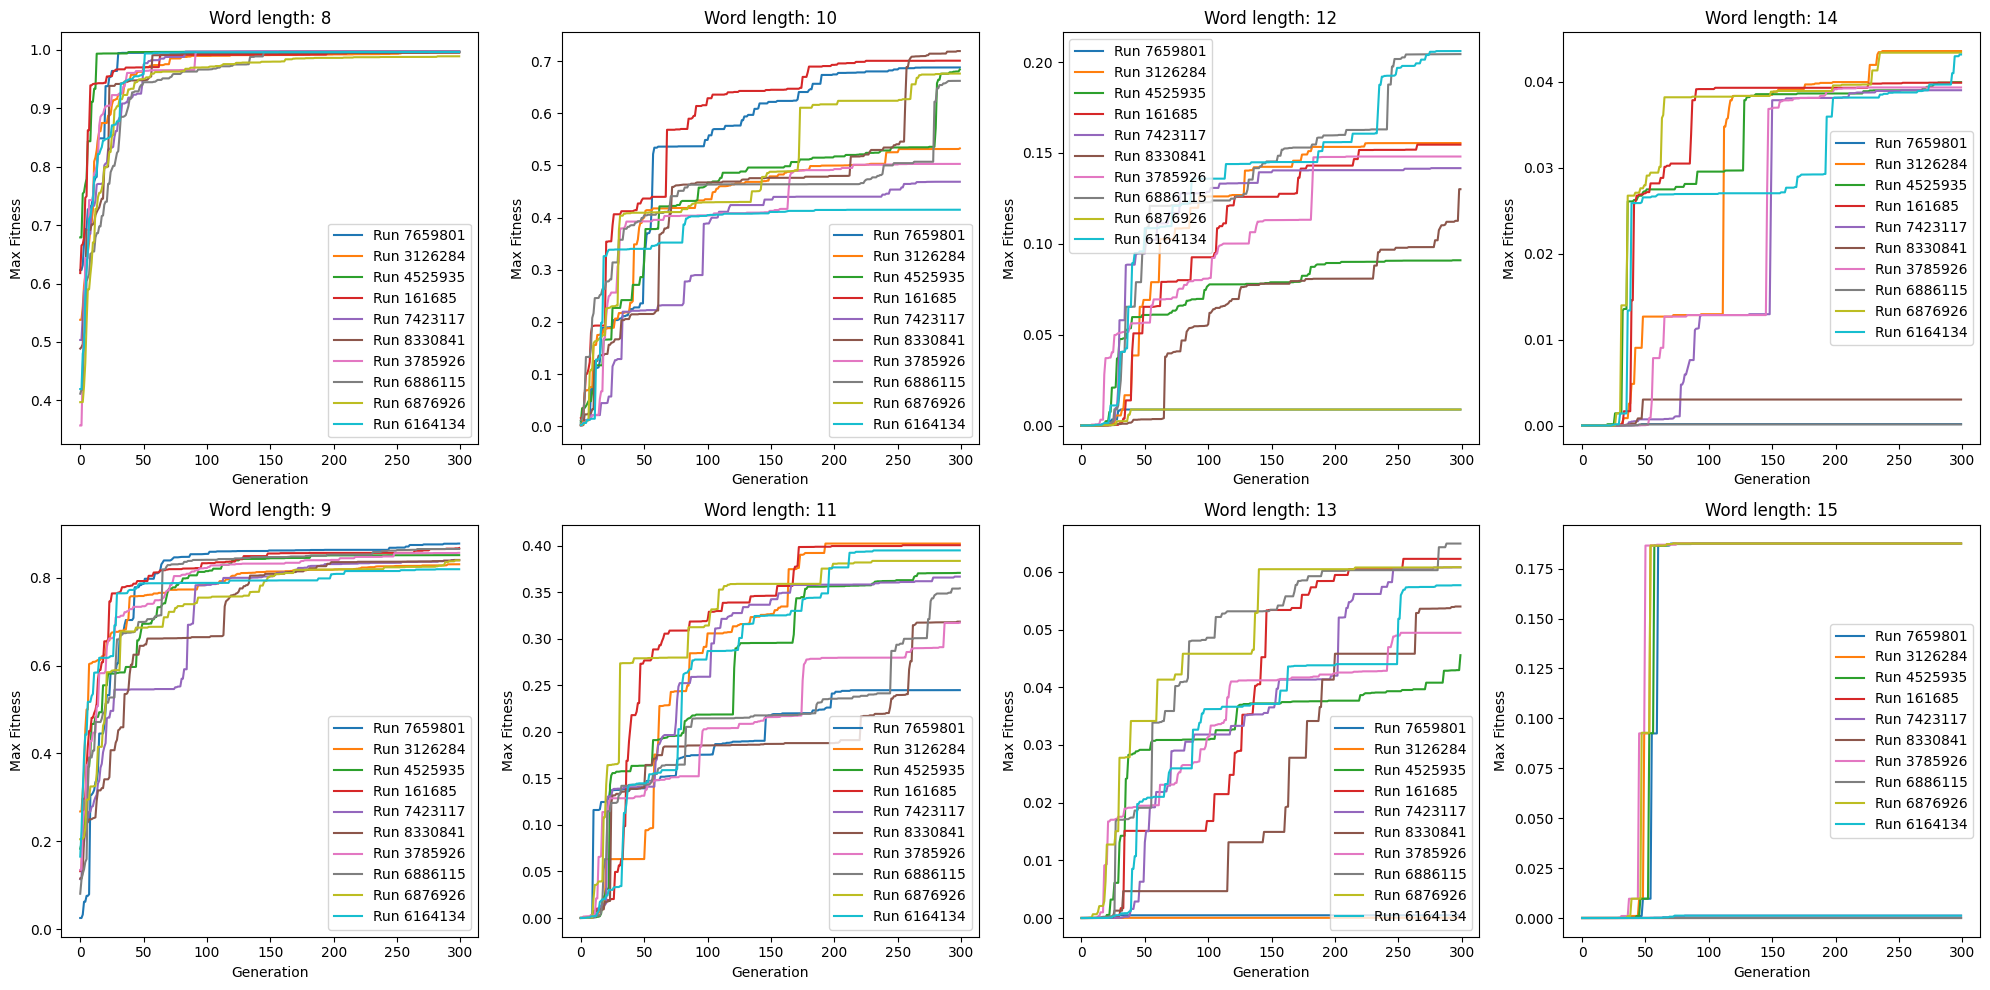

In [5]:
import matplotlib.pyplot as plt
import cloudpickle
import os

outfolder = "results"
word_lengths = [8, 9, 10, 11, 12, 13, 14, 15]

#Create a figure and a set of subplots
fig, axs = plt.subplots(2, len(word_lengths)//2, figsize=(20, 10))

for word_length in word_lengths:
    with open(os.path.join(outfolder, f"ga_{word_length}_results.pkl"), "rb") as f:
        results = cloudpickle.load(f)
        
    max_fitnesses = [ result["max_fitness"] for result in results ]

    
    ax_x = word_lengths.index(word_length) % 2
    ax_y = word_lengths.index(word_length) // 2
    
    # Plot all runs
    for result in results:
        ga = result["ga"]               
        axs[ax_x, ax_y].plot(ga.run_stats["max_fitness"], label=f"Run {result['seed']}")
        
    axs[ax_x, ax_y].set_title(f"Word length: {word_length}")
    axs[ax_x, ax_y].set_xlabel("Generation")
    axs[ax_x, ax_y].set_ylabel("Max Fitness")
    axs[ax_x, ax_y].legend()

plt.tight_layout()
plt.show()

We can see that the maximum fitness for word lengths 8 and 9 appear to have stabilized before the end of the execution.
On the other hand, the maximum fitness for word lengths 10, 11, 12, 13 and 14 were still unstable and could possibly get improved by running the algorithm for more generations.
Lastly, the maximum fitness for word length 15 is unusual, as it appears that multiple executions arrived at the same result.

Next, we can show the summarized results for the executions and the baseline.

In [23]:
import matplotlib.pyplot as plt
import cloudpickle
import os
import pandas as pd
import json

outfolder = "results"
word_lengths = [8, 9, 10, 11, 12, 13, 14, 15]

baseline_results_filename = "baseline.json"
results_filename = "results.json"

if not os.path.exists(os.path.join(outfolder, results_filename)):
    results = {}
    
    for word_length in word_lengths:
        with open(os.path.join(outfolder, f"ga_{word_length}_results.pkl"), "rb") as f:
            results_wl = cloudpickle.load(f)
            
        # Get the best result
        best_result = max(results_wl, key=lambda x: x["max_fitness"])
        
        fitness = best_result["max_fitness"]
        masks = best_result["best_individual"].masks
        cost = best_result["best_individual"].cost
        
        results[word_length] = {
            "fitness": fitness,
            "masks": [str(mask) for mask in masks],
            "cost": cost
        }
        
    with open(os.path.join(outfolder, results_filename), "w") as f:
        json.dump(results, f)
        
with open(os.path.join(outfolder, baseline_results_filename), "r") as f:
    baseline_results = json.load(f)
    
with open(os.path.join(outfolder, results_filename), "r") as f:
    results = json.load(f)
    
corporate_results = [
    {
        "length": length,
        "fitness": result["fitness"],
        "cost": result["cost"],
        "n_masks": len(result["masks"])
    }
    for length, result in baseline_results["corporate"].items()
]

extreme_breach_results = [
    {
        "length": length,
        "fitness": result["fitness"],
        "cost": result["cost"],
        "n_masks": len(result["masks"])
    }
    for length, result in baseline_results["extreme_breach"].items()
]

genetic_results = [
    {
        "length": length,
        "fitness": result["fitness"],
        "cost": result["cost"],
        "n_masks": len(result["masks"])
    }
    for length, result in results.items()
]

results_df = pd.DataFrame(corporate_results).merge(pd.DataFrame(extreme_breach_results), on="length", suffixes=("_corporate", "_extreme_breach"))
results_df = results_df.merge(pd.DataFrame(genetic_results), on="length", suffixes=("", "_genetic"))

results_df

,length,fitness_corporate,cost_corporate,n_masks_corporate,fitness_extreme_breach,cost_extreme_breach,n_masks_extreme_breach,fitness,cost,n_masks
0,8,0.972079,1605171098613760,22024,0.999705,4999855044508416,58515,0.998075,4998945864072960,30
1,9,0.562294,4999603084300800,10157,0.955987,4997928685184000,5794,0.877505,4743958039584768,28
2,10,0.386915,4998028389760000,3387,0.846787,4988401456221184,1623,0.719535,4732924205039616,29
3,11,0.208118,4989306592000000,903,0.444393,2834403868825600,119,0.402315,4917264338585600,16
4,12,0.085927,4986552000000000,379,0.175589,4411987691520000,16,0.206068,4858597775360000,18
5,13,0.032640,4863360000000000,56,0.065720,4394348800000000,10,0.064911,4917369600000000,11
6,14,0.030719,4940000000000000,11,0.034780,1857600000000000,2,0.043578,4991200000000000,7
7,15,0.000000,0,0,0.187582,3600000000000000,2,0.187582,4600000000000000,3


In [2]:
import os
import json

resultsfolder = "results"
outfolder = os.path.join(resultsfolder, "masks")
results_filename = "results.json"
 
with open(os.path.join(resultsfolder, results_filename), "r") as f:
    results = json.load(f)
    
for word_length, result in results.items():
    with open(os.path.join(outfolder, f"masks_{word_length}.txt"), "w") as f:
        for mask in result["masks"]:
            f.write(mask + "\n")